<a href="https://colab.research.google.com/github/daniel920909/Digit-Classifier/blob/main/Digit_classifier_for_real_world_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DIGIT CLASSIFIER FOR REAL-WORLD IMAGES**

In this project a Multilayer Perceptron neural network (MLP) and a Convolutional Neural Network (CNN) are built to classify digits from 0 to 9, from real-world images. For the project the SVHN dataset is used. This is an image dataset of over 600,000 digit images, obtained from house numbers in Google Street View images. 

Data augmentation is used in the CNN in order to increase the accuracy of the model, taking into account important aspects. For instance, some images might contain more than one digit, and the image augmentation could affect the algorithm if operations such as horizontal shifts result in the labeled digit not being centered in the image.

In [ ]:
#Imports
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from collections import Counter

In [ ]:
tf.__version__

'2.4.1'

In [1]:
# Run this cell to connect to Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load the dataset from Drive folder

train = loadmat('/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/data/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset

In [ ]:
#Extraction of training and testing images, as well as labels
x_train = train['X']
y_train = train['y']
x_test = test['X']
y_test = test['y']

x_train = np.moveaxis(x_train,-1,0)
x_test = np.moveaxis(x_test,-1,0)

In [ ]:
x_train.shape

(73257, 32, 32, 3)

In [ ]:
#Replace labels of 10 with label 0

y_train = np.where(y_train==10, 0, y_train)
y_test = np.where(y_test==10, 0, y_test)

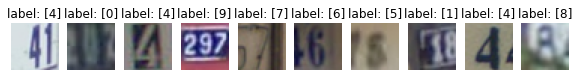

In [ ]:
#Train images examples
fig, ax = plt.subplots(1, 10, figsize=(10, 1))

index_array=np.arange(0,73257)

r = np.random.choice(index_array, size=10, replace = False )


for i in range(10):
    img = x_train[r[i],:,:,:]
    ax[i].set_axis_off()
   
    ax[i].imshow(img)
    
    ax[i].title.set_text(f"label: {y_train[r[i]]}")

In [ ]:
x_train.shape

(73257, 32, 32, 3)

In [ ]:
#Conversion to greyscale 
x_train_gs = np.mean(x_train,axis = -1, keepdims = True)
x_test_gs  = np.mean(x_test,axis = -1, keepdims = True)


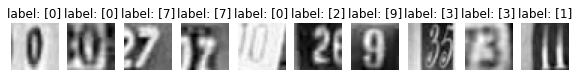

In [ ]:
#Train images examples in greyscale
fig, ax = plt.subplots(1, 10, figsize=(10, 1))

index_array=np.arange(0,73257)

r = np.random.choice(index_array, size=10, replace = False )


for i in range(10):
    img = x_train_gs[r[i],:,:,0]
    ax[i].set_axis_off()
   
    ax[i].imshow(img, cmap = 'gray')
    
    ax[i].title.set_text(f"label: {y_train[r[i]]}")

In [ ]:
#Normalization
x_train_gs = x_train_gs/255.
x_test_gs  = x_test_gs/255.


In [ ]:
y_train.shape[0]

73257

Counter({1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 0: 4948, 9: 4659})


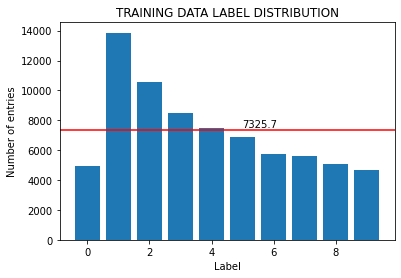

In [ ]:
#Here we check the train labels distribution  
to_count = y_train.reshape((y_train.shape[0]))
cont = Counter(list(to_count))
plt.bar(cont.keys(),cont.values())
plt.title('TRAINING DATA LABEL DISTRIBUTION')
plt.ylabel('Number of entries')
plt.xlabel('Label')
mean =  np.mean(list(cont.values()))
plt.axhline(y= mean,color='red')
plt.annotate(mean, (5,mean+200))
print(cont)

Counter({1: 5099, 2: 4149, 3: 2882, 4: 2523, 5: 2384, 7: 2019, 6: 1977, 0: 1744, 8: 1660, 9: 1595})


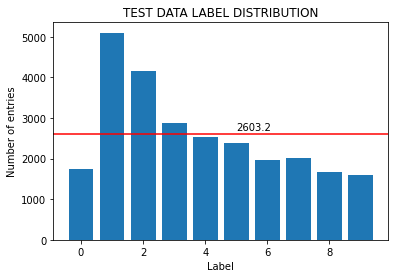

In [ ]:
#Here we check the test labels distribution  
to_count2 = y_test.reshape((y_test.shape[0]))
cont2 = Counter(list(to_count2))
plt.bar(cont2.keys(),cont2.values())

plt.title('TEST DATA LABEL DISTRIBUTION')
plt.ylabel('Number of entries')
plt.xlabel('Label')
mean2 =  np.mean(list(cont2.values()))
plt.axhline(y= mean2,color='red')
plt.annotate(mean2, (5,mean2+100))
print(cont2)

In [ ]:
#One-hot encode
y_train =  tf.keras.utils.to_categorical(np.array(y_train))
y_test = tf.keras.utils.to_categorical(np.array(y_test))

In [ ]:
y_test[21].shape

(10,)

In [ ]:
#Separate the training data
x_trainv = x_train_gs[:62268]
y_trainv = y_train[:62268]
x_trainv.shape


(62268, 32, 32, 1)

In [ ]:
#Separate the validation data
x_validation = x_train_gs[62268:73257]
y_validation = y_train[62268:73257]
x_validation.shape


(10989, 32, 32, 1)

## 2. MLP neural network classifier

In [ ]:
def get_new_MLP_model(input_shape):
            
    model = Sequential([
        Flatten(input_shape=input_shape,name='Flatten'),
        Dense(256,activation = 'relu', name='Dense_1'),
        Dense(256,activation = 'relu', name='Dense_2'),
        Dense(128,activation = 'relu', name='Dense_3'),
        Dense(10,activation = 'softmax', name= 'Dense_Final')
        
    ])
    
    model.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics=['acc', keras.metrics.Precision(name='precision'),
                                                                                        keras.metrics.Recall(name='recall'),
                                                                                        keras.metrics.AUC(name='auc')])
    
    return model 

In [ ]:
mlp_model = get_new_MLP_model(x_trainv[0].shape)

In [ ]:
mlp_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
Dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
Dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
Dense_Final (Dense)          (None, 10)                1290      
Total params: 362,378
Trainable params: 362,378
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def get_checkpoint_mlp_every_epoch():
       
    checkpoint_path = '/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_mlp_every_epoch/checkpoint_{epoch:02d}'
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             frequency = 'epoch',
                            save_weights_only = True,
                            verbose = 1)

    return checkpoint

In [ ]:
def get_checkpoint_mlp_best_only():
    
    checkpoint_path = '/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_mlp_best_only/checkpoint'
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                frequency = 'epoch',
                                 monitor = 'val_acc',
                                 save_best_only = True,
                                 save_weights_only = True,
                                verbose = 1)
    return checkpoint

In [ ]:
def get_early_stopping():
    
    early  = tf.keras.callbacks.EarlyStopping(patience=10, monitor = 'val_acc')
    
    return early 

In [ ]:
#Create checkpoints
checkpoint_every_epoch = get_checkpoint_mlp_every_epoch()
checkpoint_best_only = get_checkpoint_mlp_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]

In [ ]:
# Train the network
history = mlp_model.fit(x_trainv,y_trainv,epochs =100, batch_size = 10000,validation_data=(x_validation, y_validation),verbose=1
                        , callbacks = callbacks)

Epoch 1/100
7/7 [==============================] - 2s 111ms/step - loss: 2.3049 - acc: 0.1342 - precision: 0.1885 - recall: 0.0025 - auc: 0.5577 - val_loss: 2.2525 - val_acc: 0.1885 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6026

Epoch 00001: saving model to /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_mlp_every_epoch/checkpoint_01

Epoch 00001: val_acc improved from -inf to 0.18846, saving model to /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_mlp_best_only/checkpoint
Epoch 2/100
7/7 [==============================] - 0s 42ms/step - loss: 2.2474 - acc: 0.1902 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6046 - val_loss: 2.2417 - val_acc: 0.1881 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6095

Epoch 00002: saving model to /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_mlp_every_epoch/checkpoint_02

Epoch 00002: val_acc did not improve from 0.18846
Epoch 3/100
7/7

In [ ]:
#Clear directories (if necessary)
! rm -r /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_mlp_best_only
! rm -r /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_mlp_every_epoch

In [ ]:
# Have a look at what the checkpoint creates
! ls -lh /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_mlp_best_only

total 4.2M
-rw------- 1 root root   77 May 20 10:21 checkpoint
-rw------- 1 root root 4.2M May 20 10:21 checkpoint.data-00000-of-00001
-rw------- 1 root root 2.1K May 20 10:21 checkpoint.index


In [ ]:
#Save history
np.save('/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/History/history_mlp.npy',history.history)

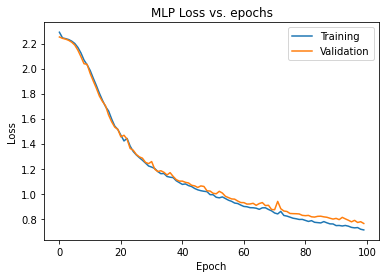

In [ ]:
#Epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MLP Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

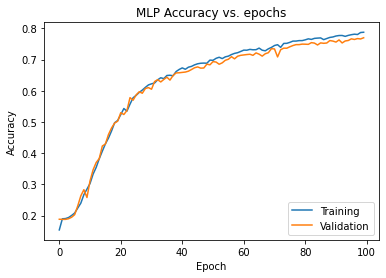

In [ ]:
# Epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('MLP Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

In [ ]:
#Load best Weights MLP
final_model_mlp  = get_new_MLP_model(x_trainv[0].shape)
final_model_mlp.load_weights('/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_mlp_best_only/checkpoint')


In [ ]:
# Evaluate the model on the train set

train_loss_mlp, train_acc_mlp, train_prec_mlp, train_recall_mlp, train_auc_mlp = final_model_mlp.evaluate(x_trainv,y_trainv, verbose=0)

print("Train loss: {:.3f}\nTrain accuracy: {:.2f}%\nTrain precision: {:.2f}%\nTrain recall: {:.2f}%\nTrain AUC: {:.2f}".format(train_loss_mlp, 100 * train_acc_mlp,100*train_prec_mlp,100*train_recall_mlp,train_auc_mlp ))

Train loss: 0.706
Train accuracy: 78.88%
Train precision: 89.65%
Train recall: 69.58%
Train AUC: 0.97


In [ ]:
# Evaluate the model on the test set

test_loss_mlp, test_acc_mlp, test_prec_mlp, test_recall_mlp, test_auc_mlp = final_model_mlp.evaluate(x_test_gs ,y_test, verbose=0)

print("Test loss: {:.3f}\nTest accuracy: {:.2f}%\nTest precision: {:.2f}%\nTest recall: {:.2f}%\nTest AUC: {:.2f}".format(test_loss_mlp, 100 * test_acc_mlp,100*test_prec_mlp,100*test_recall_mlp,test_auc_mlp ))

Test loss: 0.858
Test accuracy: 75.08%
Test precision: 85.15%
Test recall: 66.66%
Test AUC: 0.95


## 3. CNN neural network classifier

In [ ]:
def get_new_CNN_model(input_shape):
    
    
    
    model = Sequential([
        Conv2D(16,(3,3),activation = 'relu',input_shape=input_shape, padding='SAME', data_format= 'channels_last',name='Conv_1'),        
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name ='Pool_1'),
        Conv2D(32,(3,3),activation = 'relu', padding='SAME', name='Conv_2'),        
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name ='Pool_2'),
        Conv2D(64,(3,3),activation = 'relu', padding='SAME', name='Conv_3'),
        BatchNormalization(name='Batch_Normalization'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name ='Pool_3'),     
        Flatten(name='Flatten'),        
        Dense(256,activation = 'relu', name= 'Dense_1'),
        Dense(256,activation = 'relu', name= 'Dense_2'),
        Dropout(0.5, name='Dropout'),
        Dense(10,activation = 'softmax', name= 'Dense_3')
        
    ])
    
    #The learning rate. Defaults to 0.001.
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    #opt= tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False, name="SGD")

    
    model.compile(optimizer = opt , loss= 'categorical_crossentropy', metrics=['acc',keras.metrics.Precision(name='precision'),
                                                                                    keras.metrics.Recall(name='recall'),
                                                                                      keras.metrics.AUC(name='auc')])
    
    return model 

In [ ]:
cnn_model = get_new_CNN_model(x_trainv[0].shape)

In [ ]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 16, 16, 16)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 16, 16, 32)        4640      
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 8, 8, 32)          0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 8, 8, 64)          18496     
_________________________________________________________________
Batch_Normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
Pool_3 (MaxPooling2D)        (None, 4, 4, 64)         

In [ ]:
def get_checkpoint_cnn_every_epoch():
       
    checkpoint_path = '/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_cnn_every_epoch/checkpoint_{epoch:02d}'
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             frequency = 'epoch',
                            save_weights_only = True,
                            verbose = 1)

    return checkpoint 

In [ ]:
def get_checkpoint_cnn_best_only():
    
    checkpoint_path = '/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_cnn_best_only/checkpoint'
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                frequency = 'epoch',
                                 monitor = 'val_acc',
                                 save_best_only = True,
                                 save_weights_only = True,
                                verbose = 1)
    return checkpoint

In [ ]:
#Create checkpoints
checkpoint_cnn_every_epoch = get_checkpoint_cnn_every_epoch()
checkpoint_cnn_best_only = get_checkpoint_cnn_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_cnn_every_epoch, checkpoint_cnn_best_only, early_stopping]

In [ ]:
# Initialize the number of epochs and batch size for Data Augmentation
EPOCHS = 100
BS = 10000
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, shear_range=0.1, fill_mode="nearest")

In [ ]:
# Train the network with Data Augmentation
history_cnn = cnn_model.fit(aug.flow(x_trainv, y_trainv, batch_size=BS),
	validation_data=(x_validation, y_validation),verbose=1, steps_per_epoch=len(x_trainv) // BS,
	epochs=EPOCHS, callbacks = callbacks)

Epoch 1/100
6/6 [==============================] - 45s 2s/step - loss: 2.3542 - acc: 0.1382 - precision: 0.1716 - recall: 0.0014 - auc: 0.5416 - val_loss: 2.2934 - val_acc: 0.1886 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5856

Epoch 00001: saving model to /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_cnn_every_epoch/checkpoint_01

Epoch 00001: val_acc improved from -inf to 0.18855, saving model to /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_cnn_best_only/checkpoint
Epoch 2/100
6/6 [==============================] - 12s 2s/step - loss: 2.2094 - acc: 0.2004 - precision: 0.5367 - recall: 1.3000e-04 - auc: 0.6297 - val_loss: 2.2837 - val_acc: 0.2068 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6359

Epoch 00002: saving model to /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_cnn_every_epoch/checkpoint_02

Epoch 00002: val_acc improved from 0.18855 to 0.20675, saving model to /

In [ ]:
#Clear directories (if necessary)
! rm -r /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_cnn_best_only
! rm -r /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_cnn_every_epoch

In [ ]:
# Have a look at what the checkpoint creates
! ls -lh /content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_cnn_best_only

total 4.1M
-rw------- 1 root root   77 May 20 11:00 checkpoint
-rw------- 1 root root 4.1M May 20 11:00 checkpoint.data-00000-of-00001
-rw------- 1 root root 3.4K May 20 11:00 checkpoint.index


In [ ]:
#Save history
np.save('/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/History/history_cnn.npy',history_cnn.history)

In [ ]:
#Load history
#history1=np.load('/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/History/history_cnn.npy',allow_pickle='TRUE').item()


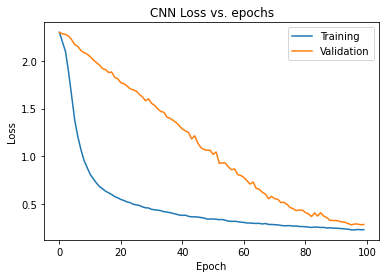

In [ ]:
#Epoch vs loss graph
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('CNN Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

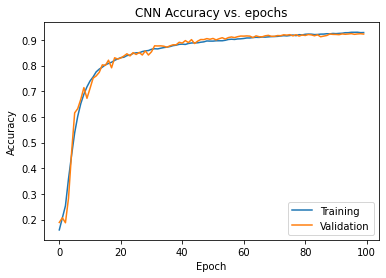

In [ ]:
# Epoch vs accuracy graph

try:
    plt.plot(history_cnn.history['accuracy'])
    plt.plot(history_cnn.history['val_accuracy'])
except KeyError:
    plt.plot(history_cnn.history['acc'])
    plt.plot(history_cnn.history['val_acc'])
plt.title('CNN Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

In [ ]:
#Load best Weights CNN
final_model_cnn  = get_new_CNN_model(x_trainv[0].shape)
final_model_cnn.load_weights('/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_cnn_best_only/checkpoint')


In [ ]:
# Evaluate the model on the train set

train_loss_cnn, train_acc_cnn, train_prec_cnn, train_recall_cnn, train_auc_cnn = final_model_cnn.evaluate(x_trainv,y_trainv, verbose=0)

print("Train loss: {:.3f}\nTrain accuracy: {:.2f}%\nTrain precision: {:.2f}%\nTrain recall: {:.2f}%\nTrain AUC: {:.2f}".format(train_loss_cnn, 100 * train_acc_cnn,100*train_prec_cnn,100*train_recall_cnn,train_auc_cnn ))

Train loss: 0.202
Train accuracy: 95.48%
Train precision: 98.23%
Train recall: 91.70%
Train AUC: 1.00


In [ ]:
# Evaluate the model on the test set

test_loss_cnn, test_acc_cnn, test_prec_cnn, test_recall_cnn, test_auc_cnn = final_model_cnn.evaluate(x_test_gs ,y_test, verbose=0)

print("Test loss: {:.3f}\nTest accuracy: {:.2f}%\nTest precision: {:.2f}%\nTest recall: {:.2f}%\nTest AUC: {:.2f}".format(test_loss_cnn, 100 * test_acc_cnn,100*test_prec_cnn,100*test_recall_cnn,test_auc_cnn ))

Test loss: 0.303
Test accuracy: 91.93%
Test precision: 95.73%
Test recall: 87.78%
Test AUC: 0.99


##4. Get model predictions

In [ ]:
#Load best Weights MLP
final_model_mlp  = get_new_MLP_model(x_trainv[0].shape)
final_model_mlp.load_weights('/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_mlp_best_only/checkpoint')

#Load best Weights CNN
final_model_cnn  = get_new_CNN_model(x_trainv[0].shape)
final_model_cnn.load_weights('/content/gdrive/MyDrive/Colab_Notebooks/Capstone_Project/checkpoints_cnn_best_only/checkpoint')

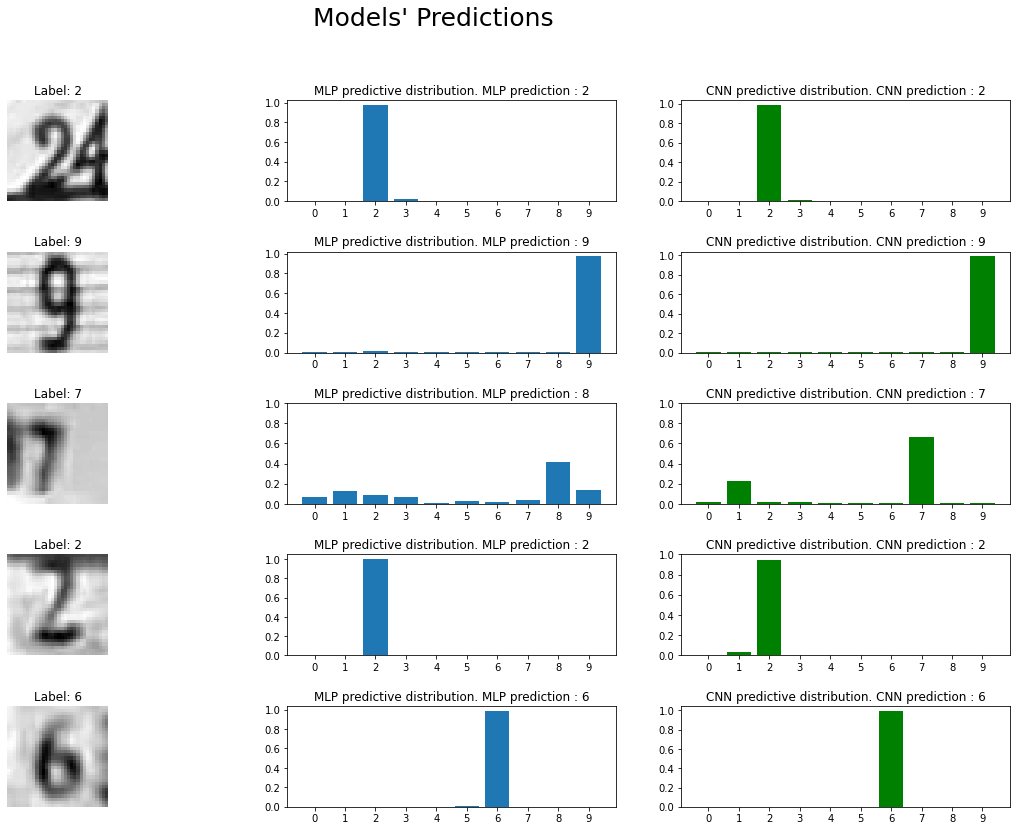

In [ ]:
#Plot MLP predictions

index_array=np.arange(0,x_test_gs.shape[0])

r = np.random.choice(index_array, size=5, replace = False )

fig, ax = plt.subplots(5, 3, figsize=(20, 13))

for i in range(5):
  img = x_test_gs[r[i],:,:,0]
  ax[i,0].set_axis_off()
  ax[i,0].imshow(img, cmap = 'gray')
  ax[i,0].title.set_text(f"Label: {np.argmax(y_test[r[i]])}")
  preds = final_model_mlp.predict(img[np.newaxis, ...,np.newaxis])

  ax[i,1].bar(np.arange(len(np.squeeze(preds))),np.squeeze(preds))
  ax[i,1].title.set_text(f"MLP predictive distribution. MLP prediction : {np.argmax(np.squeeze(preds))}")
  ax[i,1].set_xticks(np.arange(len(np.squeeze(preds))))
  ax[i,1].set_yticks(np.arange(0,1.2,0.2))

  preds_cnn = final_model_cnn.predict(img[np.newaxis, ...,np.newaxis])
  ax[i,2].bar(np.arange(len(np.squeeze(preds_cnn))),np.squeeze(preds_cnn), color ='green')
  ax[i,2].title.set_text(f"CNN predictive distribution. CNN prediction : {np.argmax(np.squeeze(preds_cnn))}")
  ax[i,2].set_xticks(np.arange(len(np.squeeze(preds_cnn))))
  ax[i,2].set_yticks(np.arange(0,1.2,0.2))


fig.suptitle("Models' Predictions", fontsize=25)
fig.subplots_adjust(hspace=0.5)